In [1]:
# =========================
# 1. Imports
# =========================
import pandas as pd
import re
import nltk
import os
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.sparse import hstack
import lightgbm as lgb
import joblib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# =========================
# 2. Download Stopwords
# =========================
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# =========================
# 3. Load Datasets
# =========================
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test_merged.csv")

print("Train shape:", df.shape)
print("Test shape:", df_test.shape)

df['content'] = df['subject'].fillna('') + " " + df['sender'].fillna('') + " " + df['body'].fillna('')
df_test['content'] = df_test['subject'].fillna('') + " " + df_test['sender'].fillna('') + " " + df_test['body'].fillna('')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Train shape: (78611, 4)
Test shape: (30000, 4)


In [14]:
# =========================
# 4. Text Cleaning
# =========================
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '<URL>', text)
    text = re.sub(r'\S+@\S+', '<EMAIL>', text)
    text = re.sub(r'[^a-z0-9\s<>]', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['content_clean'] = df['content'].apply(clean_text)
df_test['content_clean'] = df_test['content'].apply(clean_text)

# =========================
# 5. Label Encoding
# =========================
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])  # spam -> 1, ham -> 0

In [15]:
# =========================
# 6. Feature Engineering
# =========================
def extract_features(df):
    df['num_links'] = df['content'].apply(lambda x: len(re.findall(r'http\S+|www\S+', x)))
    df['num_exclamations'] = df['content'].apply(lambda x: x.count('!'))
    df['num_uppercase_words'] = df['content'].apply(lambda x: sum(1 for w in x.split() if w.isupper()))
    df['text_length'] = df['content'].apply(len)
    df['num_special_chars'] = df['content'].apply(lambda x: len(re.findall(r'[^a-zA-Z0-9\s]', x)))
    spam_words = ['free', 'win', 'click', 'prize', 'buy now']
    for word in spam_words:
        df[f'has_{word.replace(" ", "_")}'] = df['content'].apply(lambda x: int(word in x.lower()))
    return df

df = extract_features(df)
df_test = extract_features(df_test)

In [16]:
# =========================
# 7. TF-IDF Vectorization
# =========================
tfidf = TfidfVectorizer(max_features=30000, ngram_range=(1,3), min_df=5, sublinear_tf=True)
X_text_train = tfidf.fit_transform(df['content_clean'])
X_text_test = tfidf.transform(df_test['content_clean'])

feature_cols = [
    'num_links', 'num_exclamations', 'num_uppercase_words',
    'text_length', 'num_special_chars',
    'has_free', 'has_win', 'has_click', 'has_prize', 'has_buy_now'
]

X_hand_train = df[feature_cols].values
X_hand_test = df_test[feature_cols].values

X_train_combined = hstack([X_text_train, X_hand_train])
X_test_combined = hstack([X_text_test, X_hand_test])

y_train = df['label']

In [17]:
# =========================
# 8. Model Training
# =========================
nb_model = MultinomialNB()
nb_model.fit(X_train_combined, y_train)

lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_combined, y_train)

lgb_model = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7
)
lgb_model.fit(X_train_combined, y_train)

C:\Users\Dev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Info] Number of positive: 36111, number of negative: 42500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.487247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1250041
[LightGBM] [Info] Number of data points in the train set: 78611, number of used features: 28716
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.459363 -> initscore=-0.162907
[LightGBM] [Info] Start training from score -0.162907


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMClassifier(learning_rate=0.05, max_depth=7, n_estimators=500,
               objective='binary')

In [18]:
# =========================
# 9. Save Models & Encoders
# =========================
os.makedirs("models", exist_ok=True)
joblib.dump(nb_model, "models/nb_model.pkl")
joblib.dump(lr_model, "models/lr_model.pkl")
joblib.dump(lgb_model, "models/lgb_model.pkl")
joblib.dump(tfidf, "models/tfidf_vectorizer.pkl")
joblib.dump(le, "models/label_encoder.pkl")
print("✅ All models and encoders saved to 'models/' directory.")

✅ All models and encoders saved to 'models/' directory.


In [19]:
# =========================
# 10. Ensemble Predictions
# =========================
nb_probs = nb_model.predict_proba(X_test_combined)
lr_probs = lr_model.predict_proba(X_test_combined)
lgb_probs = lgb_model.predict_proba(X_test_combined)

ensemble_probs = (0.3 * nb_probs + 0.4 * lr_probs + 0.3 * lgb_probs)
ensemble_pred = ensemble_probs.argmax(axis=1)

C:\Users\Dev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Dev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\lightgbm\basic.py:1238: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


✅ Ensemble Accuracy on Test Dataset: 1.0

📊 Classification Report:
               precision    recall  f1-score   support

        spam       1.00      1.00      1.00      4255

    accuracy                           1.00      4255
   macro avg       1.00      1.00      1.00      4255
weighted avg       1.00      1.00      1.00      4255



C:\Users\Dev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


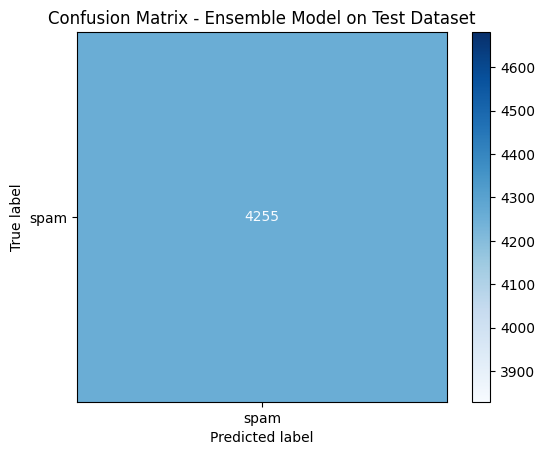

In [20]:
# =========================
# 11. Evaluate on Test Dataset
# =========================
if 'label' in df_test.columns:
    true_labels = df_test['label'].astype(str)
    pred_labels = le.inverse_transform(ensemble_pred)
    
    print("✅ Ensemble Accuracy on Test Dataset:", accuracy_score(true_labels, pred_labels))
    print("\n📊 Classification Report:\n", classification_report(true_labels, pred_labels))
    
    unique_labels = sorted(true_labels.unique())
    cm = confusion_matrix(true_labels, pred_labels, labels=unique_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
    disp.plot(cmap="Blues", values_format='d')
    plt.title("Confusion Matrix - Ensemble Model on Test Dataset")
    plt.show()
else:
    print("⚠️ No 'label' column in test dataset. Predictions only generated.")

✅ Ensemble Accuracy on Test Dataset: 1.0

📊 Classification Report:
               precision    recall  f1-score   support

        spam       1.00      1.00      1.00      4255

    accuracy                           1.00      4255
   macro avg       1.00      1.00      1.00      4255
weighted avg       1.00      1.00      1.00      4255



C:\Users\Dev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


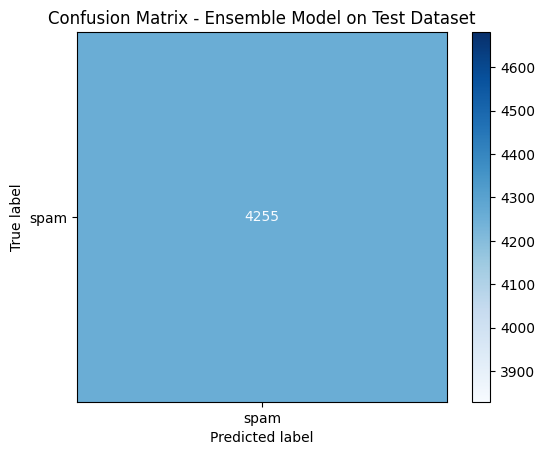

In [21]:
# =========================
# 11. Evaluate on Test Dataset
# =========================
if 'label' in df_test.columns:
    # ----- Case 1: When test data has ground truth -----
    true_labels = df_test['label'].astype(str)
    pred_labels = le.inverse_transform(ensemble_pred)
    
    print("✅ Ensemble Accuracy on Test Dataset:", accuracy_score(true_labels, pred_labels))
    print("\n📊 Classification Report:\n", classification_report(true_labels, pred_labels))
    
    unique_labels = sorted(true_labels.unique())
    cm = confusion_matrix(true_labels, pred_labels, labels=unique_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
    disp.plot(cmap="Blues", values_format='d')
    plt.title("Confusion Matrix - Ensemble Model on Test Dataset")
    plt.show()

else:
    # ----- Case 2: When test data has no ground truth -----
    pred_labels = le.inverse_transform(ensemble_pred)

    # Add predictions to DataFrame
    df_test["predicted_label"] = pred_labels

    # Count predictions
    spam_count = (df_test["predicted_label"] == "spam").sum()
    ham_count = (df_test["predicted_label"] == "ham").sum()

    print("⚡ Predictions generated (no ground truth available).")
    print(f"📬 Total Emails: {len(df_test)}")
    print(f"🧾 HAM: {ham_count}")
    print(f"🚨 SPAM: {spam_count}")

    # Save predictions for reference
    df_test.to_csv("test_predictions.csv", index=False)
    print("\n💾 Predictions saved to 'test_predictions.csv'")


In [22]:
# =========================
# 12. Predict Function (Reusable)
# =========================
def predict_spam(subject, sender='', body=''):
    """Predict if an email is spam or ham and show confidence."""
    content = f"{subject} {sender} {body}"
    content_clean = clean_text(content)
    
    X_text_new = tfidf.transform([content_clean])
    num_links = len(re.findall(r'http\S+|www\S+', content))
    num_exclamations = content.count('!')
    num_uppercase_words = sum(1 for w in content.split() if w.isupper())
    text_length = len(content)
    num_special_chars = len(re.findall(r'[^a-zA-Z0-9\s]', content))
    spam_words_vals = [int(word in content.lower()) for word in ['free','win','click','prize','buy now']]
    
    X_hand_new = np.array([[num_links, num_exclamations, num_uppercase_words,
                            text_length, num_special_chars] + spam_words_vals])
    X_new = hstack([X_text_new, X_hand_new])
    
    nb_probs_new = nb_model.predict_proba(X_new)
    lr_probs_new = lr_model.predict_proba(X_new)
    lgb_probs_new = lgb_model.predict_proba(X_new)
    
    ensemble_probs_new = (0.3 * nb_probs_new + 0.4 * lr_probs_new + 0.3 * lgb_probs_new)
    pred_label = ensemble_probs_new.argmax(axis=1)[0]
    confidence = ensemble_probs_new[0, pred_label] * 100  # percentage
    
    predicted_class = le.inverse_transform([pred_label])[0]
    print(f"Predicted: {predicted_class.upper()} (Confidence: {confidence:.2f}%)")
    
    return predicted_class, confidence